# Hands-on 01: Uso de modelos de propagação para análises sistêmicas

# Parte 01: Avaliação de cobertura celular


### Objetivos
As metas desse tutorial são ajudar o usuário a:
- Criar um Grid Hexagonal para modelar cobertura de Estações Rádio Base;
- Analisar potência recebida visualmente por meio de _Radio Environment Maps_ (REMs);
- Fazer exemplo de estudo de _Outage_ de potência.

## Prática 01: Criação de grid celular hexagonal

Vamos escrever um código para criação de um mapa de cobertura de 7 (sete) estações rádio base (ERBs), como ilustrado na figura a seguir.


![fig_hex](../FIGS/HD_01_MATLAB/fig_hex.png)


A modelagem tem as seguintes características:

- Grid com células hexagonais;
- ERBs macrocelulares com altura de 30 m;
- Estações móveis com altura média de 1,8 m;
- O raio de cada hexágono é um parâmetro ajustável denominado dR;
- As dimensões do grid celular com as 7 ERBs é 5dR x 6 $\sqrt{\frac{3}{4}}$ dR;
- Para fins de definição da Outage (falha da conexão por falta de potência), a sensibilidade do receptor é considerada igual a -104 dBm ([fonte](http://www.comlab.hut.fi/opetus/260/1v153.pdf));
- A EIRP (Effective Isotropic Radiated Power) é 57 dBm ([Discussão interessante sobre $P_{TX}$ e EIRP](https://under-linux.org/entry.php?b=1384)). Esse valor é compatível com receptores do GSM ([fonte](https://pt.slideshare.net/naveenjakhar12/gsm-link-budget));
- Somente a perda de percurso é considerada como manifestação de canal. Assim, a potência recebida será calculada com o modelo de Okumura-Hata para cidades urbanas grandes;
- A frequência da portadora é um parâmetro ajustável denominado dFc;
- Para evitar problema numéricos (divisão por zero ou logaritmo de zero), vamos modelar um raio de segurança. Para efeito de cálculo da potência recebida, todos os pontos menores que uma distância denominada dRMin, terão potência recebida igual aquela calculada usando dRMin como distância.

A ideia é calcular a potência recebida em dBm para pontos equidistantes em toda a ára de cobertura. A distância entre os pontos de medição foi definida como o próximo valor inteiro maior que $\frac{dR}{10}$. Esse valor pode ser ajustado para melhor visualizar os REMs. 

A figura a seguir ilustra essa modelagem.
![fig_fig_rem_model](../FIGS/HD_01_MATLAB/fig_rem_model.png)

**Dica importante de programação com Matlab:** O Matlab é otimizado para trabalhar com matrizes (e vetores). Assim, algumas operações devem ser vetorizadas ou matricializadas, evitando laços. Vamos escrever o código evitando ao máximo laço FOR.


**Passo 01:** Crie uma função chamada **fDrawSector.py** com o seguinte código. Ela servirá para desenhar um hexágono de centro e raio especificados como parâmetro. Tal função servira para termos certeza que o posicionamento das ERBs estão corretos.

In [41]:
%%file fDrawSector.py
import numpy as np
import matplotlib.pyplot as plt

def fDrawSector(dR, dCenter):
    # Calcula os vértices do hexágono
    vtHex = []
    for ie in range(6):
        angle = (ie) * np.pi / 3
        x = dR * np.cos(angle)
        y = dR * np.sin(angle)
        vtHex.append(x + 1j * y)  # número complexo, como no MATLAB

    vtHex = np.array(vtHex) + (dCenter[0] + 1j * dCenter[1])

    # Fecha o polígono
    vtHexp = np.append(vtHex, vtHex[0])

    # Plota
    plt.plot(vtHexp.real, vtHexp.imag, 'k')
    plt.axis('equal')

Overwriting fDrawSector.py


**Passo 02:** Para testar a função, vamos criar um hexágono centrado no ponto (100,50) e com raio 100. Para isso execute o seguinte comando no Matlab (você precisa colocar o arquivo **fDrawSector.py** na pasta de trabalho do Matlab).   

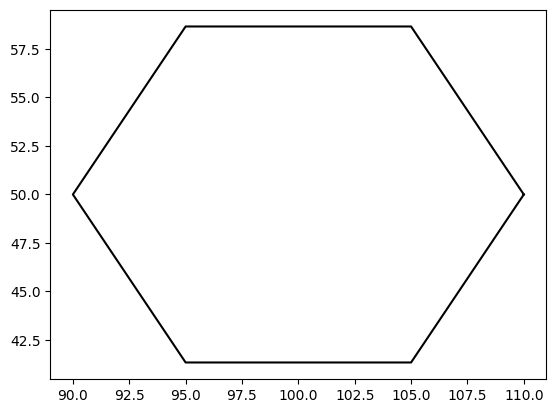

In [42]:
fDrawSector(10, (100, 50))
plt.show()

**Passo 03:** Crie uma função chamada **fDrawDeploy.py** com o seguinte código. Ela servirá para desenhar o grid celular. Tal função servirá para termos certeza que o posicionamento das ERBs estão corretos.

In [43]:
%%file fDrawDeploy.py
import numpy as np
import matplotlib.pyplot as plt

fDrawDeploy(dR, vtBs):
    """
    Desenha setores hexagonais em torno das BSs
    dR   : raio do hexágono
    vtBs : lista/array de posições das BSs (números complexos ou tuplas (x,y))
    """
    # NÃO usar plt.figure() aqui -> assim desenha na mesma figura
    
    # Desenha hexágonos para cada BS
    for bs in vtBs:
        if isinstance(bs, (tuple, list)):
            fDrawSector(dR, (bs[0], bs[1]))
        else:
            fDrawSector(dR, (bs.real, bs.imag))
    
    # Plota posição das BSs como quadrados pretos
    x = [bs[0] if isinstance(bs, (tuple, list)) else bs.real for bs in vtBs]
    y = [bs[1] if isinstance(bs, (tuple, list)) else bs.imag for bs in vtBs]
    plt.plot(x, y, 'sk')
    plt.axis('equal')

Overwriting fDrawDeploy.py


**Passo 04:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson1_P1_1.py**). Nesse código, vamos criar um vetor com a posição das 7 ERBs. A posição é ajustada para que a referência, i.e., o ponto (0,0) seja o canto inferior esquerdo do grid. Também já criamos o grid com a dimensão especificada no hands-on.

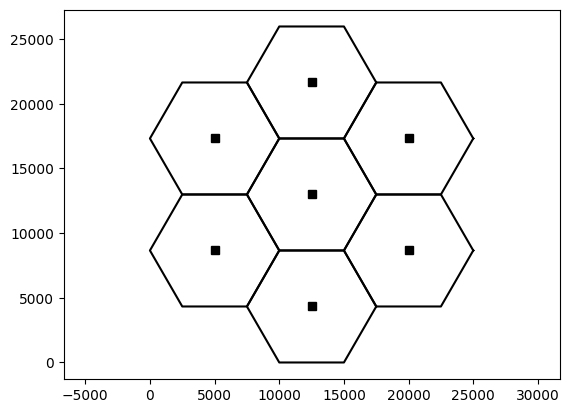

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Parâmetros =====
dR = 5e3  # Raio do Hexágono
dIntersiteDistance = 2 * np.sqrt(3/4) * dR   # Distância entre ERBs (somente informação)
dDimX = 5 * dR                               # Dimensão X do grid
dDimY = 6 * np.sqrt(3/4) * dR                # Dimensão Y do grid

# ===== Posições das BSs (grid hexagonal com 7 células) =====
vtBs = [0 + 0j]  # célula central (como número complexo)

dOffset = np.pi / 6
for iBs in range(2, 8):  # iBs = 2:7 em MATLAB
    pos = dR * np.sqrt(3) * np.exp(1j * ((iBs - 2) * np.pi/3 + dOffset))
    vtBs.append(pos)

# Ajuste de posição (desloca tudo para ficar dentro do grid definido)
vtBs = [bs + (dDimX/2 + 1j * dDimY/2) for bs in vtBs]

# ===== Desenha setores hexagonais =====
fDrawDeploy(dR, vtBs)
plt.axis('equal')
plt.show()


## Prática 02: Criação dos pontos de medição

Vamos escrever um código para criação dos pontos de medição do REM de cada ERB. A ideia é criar 7 matrizes, cada uma com a posição relativa dos pontos de medição de todo o grid para cada ERB. Assim, teremos uma matriz de pontos de medição para cada ERB, nas quais o ponto (0,0) é centralizado em cada ERB respectiva. Essas matrizes serão armazenadas em uma matriz 3D denomida **mtPosEachBS**. Cada elemento da matriz (pocisionamento de cada ponto de medição) é modelado como um número complexo X + jY, sendo X a posição na abscissa e, Y a posição no eixo das ordenadas.

**Passo 01:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson1_P21.py**). Nesse código, vamos criar:

- Um vetor com a posição das 7 ERBs. A posição é ajustada para que a referência, i.e., o ponto (0,0) seja o canto inferior esquerdo do grid. Também já criamos o grid com a dimensão especificada no hands-on.
- Criação da matriz 3D **mtPosEachBS** com as matrizes de pontos de medição de cada ERB, nas quais o ponto (0,0) é centralizado em cada ERB respectiva. 
- Plot das posições relativas dos pontos de medição de cada ERB.

<Figure size 640x480 with 0 Axes>

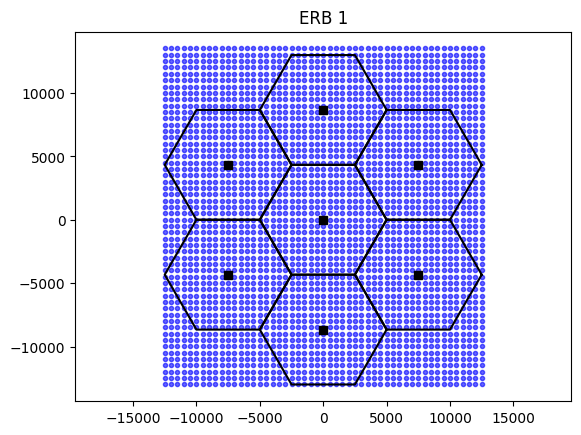

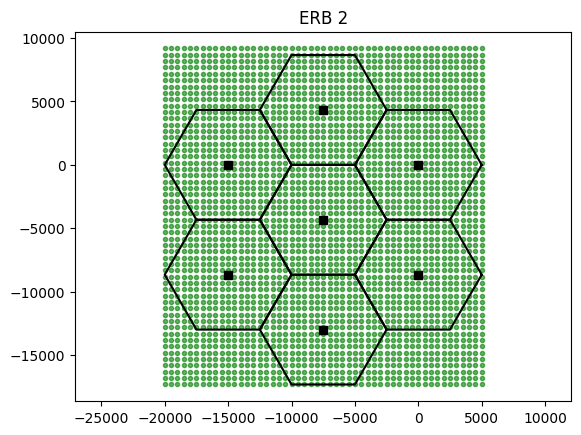

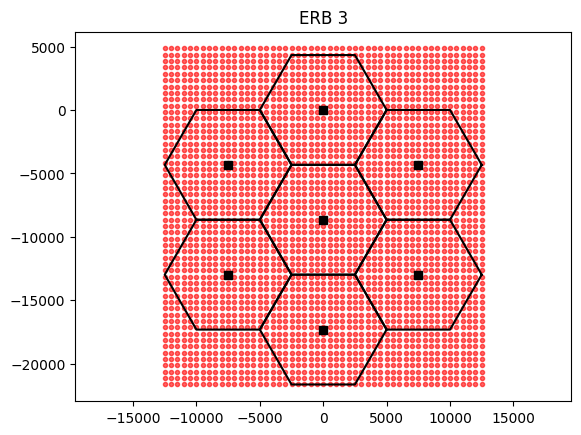

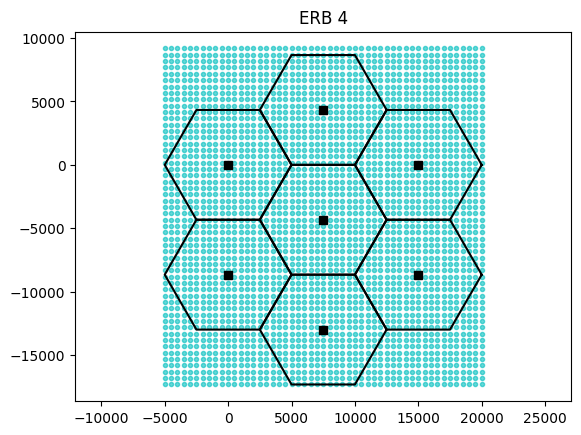

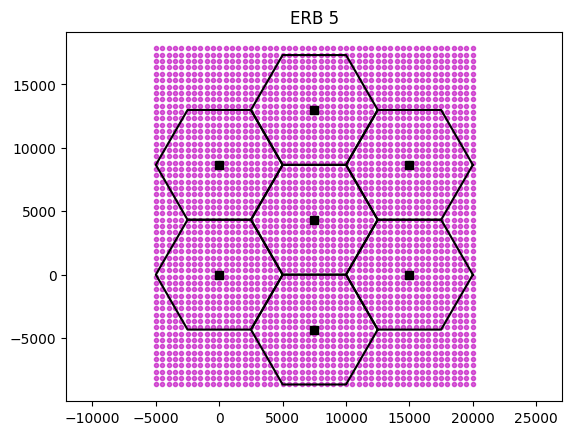

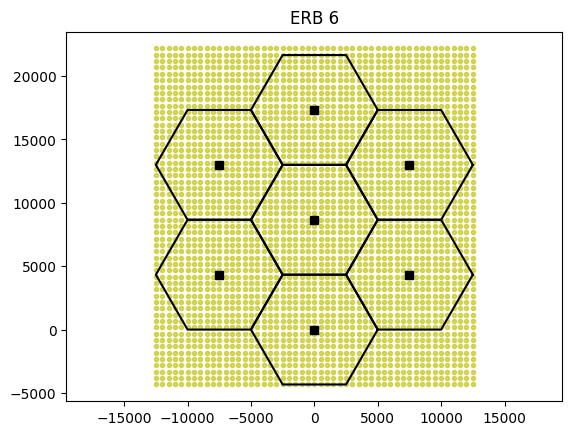

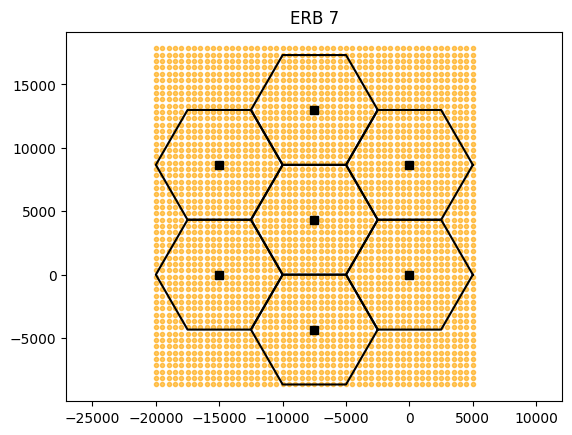

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# === Script principal ===
plt.close('all')

# Entrada de parâmetros
dR = 5e3  # Raio do Hexágono
dPasso = int(np.ceil(dR / 10))               # Resolução do grid
dDimX = 5 * dR                               # Dimensão X
dDimY = 6 * np.sqrt(3/4) * dR                # Dimensão Y

# Posições das BSs (7 células: 1 central + 6 ao redor)
vtBs = [0 + 0j]
dOffset = np.pi / 6
for iBs in range(2, 8):  # iBs = 2:7
    pos = dR * np.sqrt(3) * np.exp(1j * ((iBs - 2) * np.pi/3 + dOffset))
    vtBs.append(pos)

# Ajuste para canto inferior esquerdo
vtBs = [bs + (dDimX/2 + 1j * dDimY/2) for bs in vtBs]

# Grid de pontos
dDimY = dDimY + (dDimY % dPasso)
dDimX = dDimX + (dDimX % dPasso)

mtPosx, mtPosy = np.meshgrid(np.arange(0, dDimX + dPasso, dPasso),
                             np.arange(0, dDimY + dPasso, dPasso))

# === Única figura para todas ERBs ===
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange']  # cores diferentes p/ cada ERB

for iBsD in range(len(vtBs)):
    plt.figure()
    # pontos relativos à ERB
    mtPosRel = (mtPosx + 1j * mtPosy) - vtBs[iBsD]

    # plota grid de pontos (cor diferente por ERB)
    plt.plot(mtPosRel.real.ravel(),
             mtPosRel.imag.ravel(),
             'o', color=colors[iBsD % len(colors)], markersize=3, alpha=0.6,
             label=f"ERB {iBsD+1}")

    # desenha células deslocadas
    fDrawDeploy(dR, [bs - vtBs[iBsD] for bs in vtBs])
    plt.axis('equal')
    plt.title(f"ERB {iBsD+1}")

plt.show()


**A execução do código resulta em:**
1. Sete gráficos mostrando o grid celular e os pontos de medição **relativos** a cada ERB. 
2. A ERB está identificada no título de cada gráfico;
3. Note que o ponto (0,0) de cada ERB (de cada gráfico), i.e. seu posicionamento, é diferente. Na ERB 1, o ponto (0,0) está no centro (posição da ERB 1) e, na ERB 6, o ponto (0,0) está no centro do hexágono inferior, posição central da ERB. 

**Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

## Prática 03: Cálculo e plot da potência recebida 

Vamos escrever um código para o cálculo da potência recebida nos pontos de medição do REM de cada ERB, e também considerando a composição das 7 ERBs. Como especificado no hands-on, precisamos considerar que a potência recebida de cada ponto de medição é a maior potência recebida em relação as 7 ERBs.

**Passo 01:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson1_p31.py**). Nesse código, vamos:

- Criar sete matrizes de distâncias relativas de cada ponto de medição e para cada ERB (matrizes **mtDistEachBs**). Aplicaremos o raio de segurança a essas distâncias;
- Com as distâncias, usaremos o modelo de Okumura-Hata para calcular a perda de percurso (matrizes **mtPldB**);
- Com a EIRP e a perda de percurso, calcularemos a potência recebida de cada ERB em cada ponto de medição. Para cada ERB montaremos a matriz **mtPowerEachBSdBm**;
- Montaremos uma única matriz **mtPowerFinaldBm** com a maior potência recebida em cada ponto de medição;
- Plotaremos o REM de cada ERB e da composição das 7 ERBs.



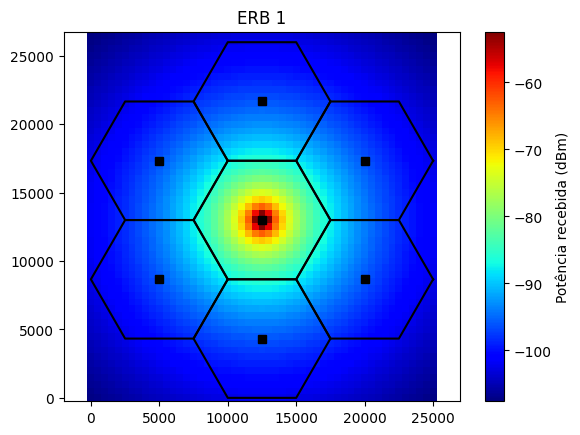

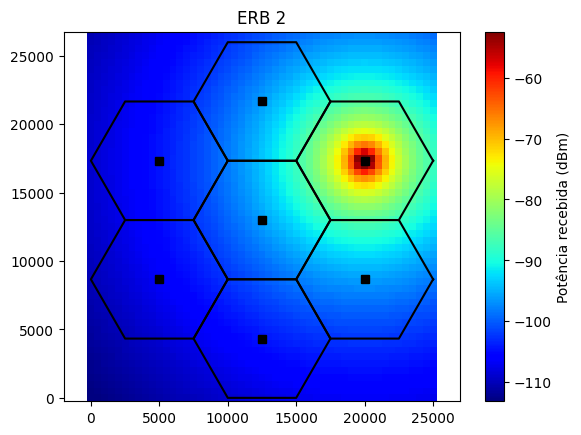

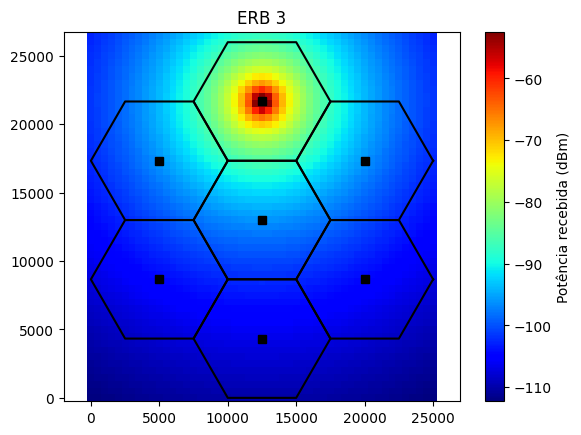

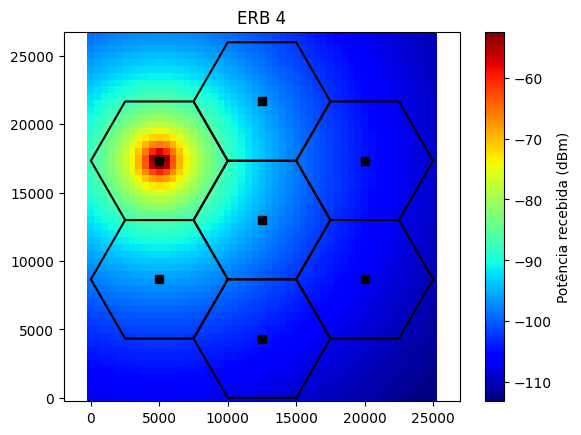

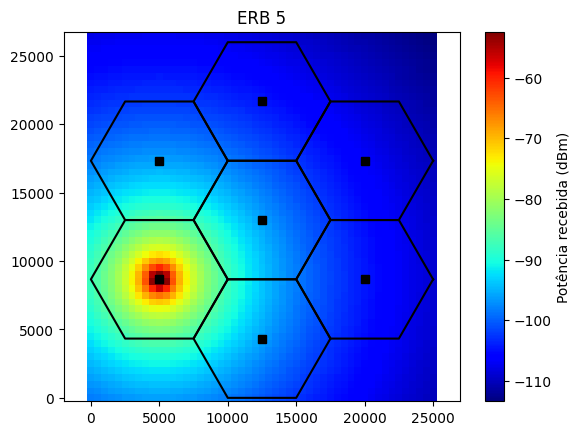

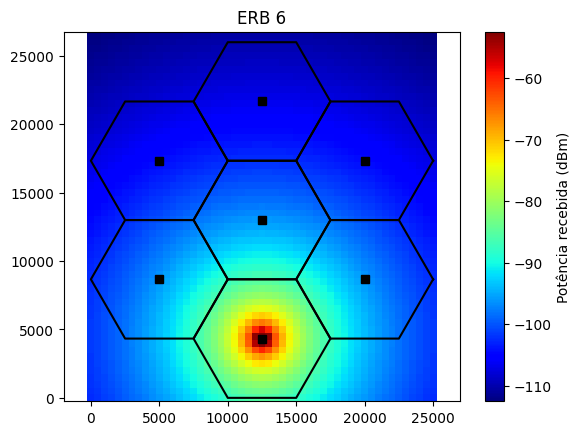

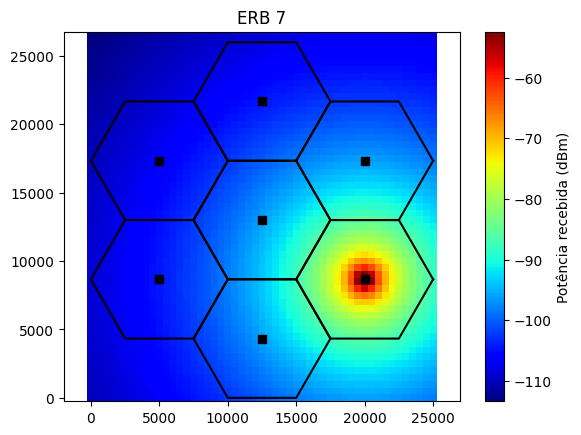

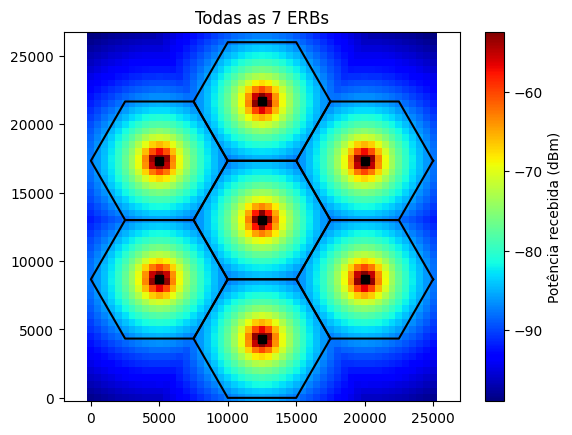

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# === Entrada de parâmetros ===
dR = 5e3     # Raio do Hexágono (m)
dFc = 800    # Frequência da portadora (MHz)

dPasso = int(np.ceil(dR / 10))        # Resolução do grid
dRMin = dPasso                        # Raio de segurança
dIntersiteDistance = 2 * np.sqrt(3/4) * dR
dDimX = 5 * dR
dDimY = 6 * np.sqrt(3/4) * dR
dPtdBm = 57                           # EIRP (dBm)
dPtLinear = 10 ** (dPtdBm / 10) * 1e-3
dHMob = 5                             # Altura do receptor (m)
dHBs = 30                             # Altura da BS (m)
dAhm = 3.2 * (np.log10(11.75 * dHMob))**2 - 4.97

# === Posições das BSs (7 células: 1 central + 6 ao redor) ===
vtBs = [0 + 0j]
dOffset = np.pi / 6
for iBs in range(2, 8):  # 2..7
    pos = dR * np.sqrt(3) * np.exp(1j * ((iBs - 2) * np.pi/3 + dOffset))
    vtBs.append(pos)

# Ajuste para canto inferior esquerdo
vtBs = [bs + (dDimX/2 + 1j * dDimY/2) for bs in vtBs]

# === Grid de pontos ===
dDimY = dDimY + (dDimY % dPasso)
dDimX = dDimX + (dDimX % dPasso)

mtPosx, mtPosy = np.meshgrid(
    np.arange(0, dDimX + dPasso, dPasso),
    np.arange(0, dDimY + dPasso, dPasso)
)

# === Matriz de potência recebida máxima ===
mtPowerFinaldBm = -np.inf * np.ones_like(mtPosy, dtype=float)

# === Loop nas 7 ERBs ===
for iBsD in range(len(vtBs)):
    # Posições relativas
    mtPosEachBS = (mtPosx + 1j * mtPosy) - vtBs[iBsD]
    mtDistEachBs = np.abs(mtPosEachBS)

    # Raio mínimo (evita distâncias muito pequenas)
    mtDistEachBs[mtDistEachBs < dRMin] = dRMin

    # Perda de percurso (Okumura-Hata, urbano)
    mtPldB = (
        69.55
        + 26.16 * np.log10(dFc)
        + (44.9 - 6.55 * np.log10(dHBs)) * np.log10(mtDistEachBs / 1e3)
        - 13.82 * np.log10(dHBs)
        - dAhm
    )

    # Potência recebida (dBm)
    mtPowerEachBSdBm = dPtdBm - mtPldB

    # === Plot da REM individual ===
    plt.figure()
    plt.pcolormesh(mtPosx, mtPosy, mtPowerEachBSdBm,
                   shading='auto', cmap='jet')
    plt.colorbar(label="Potência recebida (dBm)")
    fDrawDeploy(dR, vtBs)
    plt.axis('equal')
    plt.title(f"ERB {iBsD+1}")

    # Atualiza matriz final (máxima potência entre BSs)
    mtPowerFinaldBm = np.maximum(mtPowerFinaldBm, mtPowerEachBSdBm)

# === Plot final (todas ERBs) ===
plt.figure()
plt.pcolormesh(mtPosx, mtPosy, mtPowerFinaldBm,
               shading='auto', cmap='jet')
plt.colorbar(label="Potência recebida (dBm)")
fDrawDeploy(dR, vtBs)
plt.axis('equal')
plt.title("Todas as 7 ERBs")
plt.show()


## Prática 04: Cálculo da Outage 

Vamos escrever um código para a taxa de outage de potência, i.e., a porcentagem de pontos que estão com potência abaixo da sensibilidade do receptor. 

**Passo 01:** Inspecione, insira o código a seguir no editor do Matlab (salve com o nome **handson1_p41.py**). Nesse código, vamos:

- Exluir todos os plots;
- Definir a sensibilidade do receptor (dSensitivity = -104);
- Aumentar a resolução do grid, i.e., o número de pontos de medição (dPasso = dR/50);

In [51]:
import numpy as np

# === Frequências em MHz ===
vtFc = [800, 900, 1800, 1900, 2100]

# Loop sobre cada frequência
for dFc in vtFc:
    # Entrada de parâmetros
    dR = 10e3                 # Raio do Hexágono (m)
    dPasso = int(np.ceil(dR / 50))
    dRMin = dPasso
    dIntersiteDistance = 2 * np.sqrt(3/4) * dR
    dDimX = 5 * dR
    dDimY = 6 * np.sqrt(3/4) * dR
    dPtdBm = 57               # EIRP (dBm)
    dPtLinear = 10 ** (dPtdBm / 10) * 1e-3
    dSensitivity = -104       # Sensibilidade do receptor (dBm)
    dHMob = 5                 # Altura do receptor (m)
    dHBs = 30                 # Altura do transmissor (m)
    dAhm = 3.2 * (np.log10(11.75 * dHMob))**2 - 4.97

    # === Posições das BSs (7 células: 1 central + 6 ao redor) ===
    vtBs = [0 + 0j]
    dOffset = np.pi / 6
    for iBs in range(2, 8):
        pos = dR * np.sqrt(3) * np.exp(1j * ((iBs - 2) * np.pi/3 + dOffset))
        vtBs.append(pos)
    # Ajuste para canto inferior esquerdo
    vtBs = [bs + (dDimX/2 + 1j * dDimY/2) for bs in vtBs]

    # === Grid de pontos ===
    dDimY = np.ceil(dDimY + (dDimY % dPasso))
    dDimX = np.ceil(dDimX + (dDimX % dPasso))
    mtPosx, mtPosy = np.meshgrid(np.arange(0, dDimX + dPasso, dPasso),
                                 np.arange(0, dDimY + dPasso, dPasso))

    # === Inicializa potência máxima em cada ponto ===
    mtPowerFinaldBm = -np.inf * np.ones_like(mtPosy, dtype=float)

    # === Loop sobre cada BS ===
    for iBsD in range(len(vtBs)):
        mtPosEachBS = (mtPosx + 1j * mtPosy) - vtBs[iBsD]
        mtDistEachBs = np.abs(mtPosEachBS)
        mtDistEachBs[mtDistEachBs < dRMin] = dRMin  # Raio de segurança

        # Okumura-Hata (urbano)
        mtPldB = (
            69.55
            + 26.16 * np.log10(dFc)
            + (44.9 - 6.55 * np.log10(dHBs)) * np.log10(mtDistEachBs / 1e3)
            - 13.82 * np.log10(dHBs)
            - dAhm
        )

        mtPowerEachBSdBm = dPtdBm - mtPldB

        # Atualiza potência máxima
        mtPowerFinaldBm = np.maximum(mtPowerFinaldBm, mtPowerEachBSdBm)

    # === Cálculo da taxa de outage (limite 10%) ===
    dOutRate = 100 * np.sum(mtPowerFinaldBm < dSensitivity) / mtPowerFinaldBm.size
    print(f"Frequência da portadora = {dFc} MHz")
    print(f"Taxa de outage = {dOutRate:.2f} %\n")


Frequência da portadora = 800 MHz
Taxa de outage = 7.70 %

Frequência da portadora = 900 MHz
Taxa de outage = 10.99 %

Frequência da portadora = 1800 MHz
Taxa de outage = 46.96 %

Frequência da portadora = 1900 MHz
Taxa de outage = 50.99 %

Frequência da portadora = 2100 MHz
Taxa de outage = 57.79 %




##  Entrega 01: Definição de raio celular para uma Outage planejada

Escreva um código para determinar o raio celular aproximado para cada frequência da portadora do exemplo acima, considerando uma Outage de potência máxima de 10%. Faça isso considerando os seguintes requisitos:
- Contabilize para Outage somente a área delimitada pelos hexágonos;
- Utilize alguma estratégia de busca baseada em gradiente para achar o raio, sem a necessidade de busca em força bruta.


##  Entrega 02: Ajuste do modelo de propagação
Faça a avaliação acima considerando o modelo COST Hata model (COST 231), que é mais fiel para frequências acima de 900 MHz. Diserte sobre os resultados, comparando qualitativamente com o que foi encontrado na **Entrega 01**.